# Rendu de projet données immobilières

Useful links : [Subject](https://simplonline.co/briefs/327207de-b68d-4563-bc7a-249a7637782d) | [Original dataset (.csv)](https://www.data.gouv.fr/fr/datasets/5c4ae55a634f4117716d5656/) <br>
This project was realized by : Adil, Marianne, Nidal, Théo & Zohra

Technical specifications :
>- PostgreSQL v.12 and upper 
>- Python3
>- [PgAdmin4]

### Table of content :
- [Deliverable](#delivrable)
    - [Dictionnaire de données - Data Dictionary](#dict)
    - [Modèle Conceptuel de données (MCD)](#mcd)
    - [Modèle Physique de données (MPD)](#mpd)
- [Database](#db)
    - [Create database script](#dbcd)
    - [Create tables script](#dbct)
    - [Data import via Python](#dbp)
- [Table of questions](#tq)

------

### <a name="delivrable"></a> Delivrable


### <a name="dict"></a> Dictionnaire de données

|Entité|Code propriété|Nom de propriété|Description|Format|
|--|--|--|--|--|
|Transaction|date_mutation|Date mutation|Date de signature de l’acte (au format JJ/MM/AAAA) – Une restitution au format AAAA/MM/JJ (norme ISO 8601) est prévue à compter de la mise à jour d’octobre 2019.|DATE (AAAA-MM-JJ)|
|Transaction|valeur_fonciere|Valeur foncière|Il s’agit du montant ou de l’évaluation déclaré dans le cadre d’une mutation à titre onéreux. La valeur foncière est le prix net vendeur. La TVA est incluse. Ce prix n’inclut pas, en revanche, les frais de notaires.|FLOAT (precis. 2)|
|Localisation|code_postal|Code postal|Code postal de la commune|VARCHAR|
|Localisation|code_departement|Code du département|Référence cadastrale de la parcelle|VARCHAR|
|Bien|code_type_local|Code type local|1 : maison ; 2 : appartement ; 3 : dépendance (isolée) ; 4 : local industriel et commercial ou assimilés|INT|
|Bien|surface_reel_bati|Surface réel batie|La surface réelle est la surface mesurée au sol entre les murs ou séparations et arrondie au mètre carré inférieur. Les surfaces des dépendances ne sont pas prises en compte.|INT|
|Bien|nb_pieces_principales|Nombre de pièces principales|Les cuisines, salles d’eau et dépendances ne sont pas prises en compte.|INT|
|Commune|code_commune|Code de la commune|Référence cadastrale de la parcelle|VARCHAR|
|Commune|commune|Nom de la commune||VARCHAR|

-----------
#### <a name="mcd"></a> Modèle Conceptuel de Données (MCD)

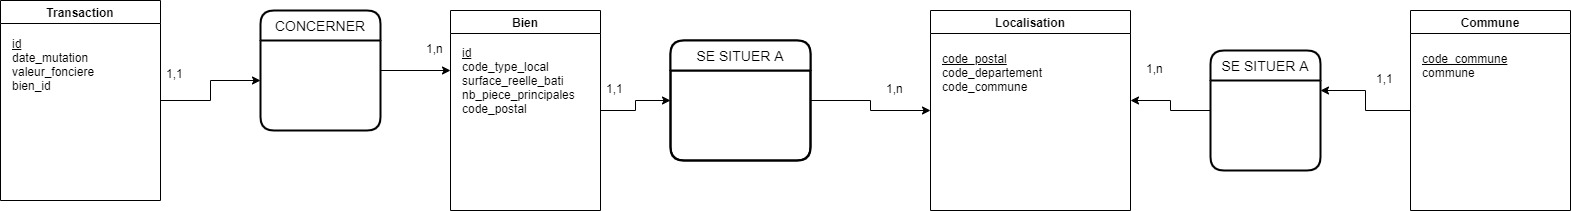

------

#### <a name="mpd"></a> Modèle Physique de Données (MPD)

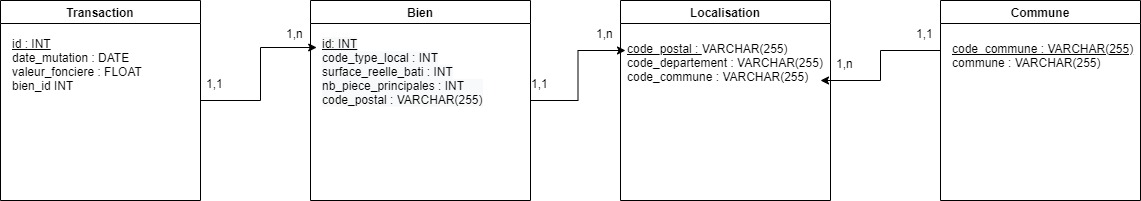

-----

### <a name="db"></a> Database

### <a name="dbcd"></a> Create database

```sql
DROP DATABASE IF EXISTS immo_db;
CREATE DATABASE immo_db;
```

### <a name="dbct"></a> Create tables

```sql
BEGIN;

DROP TABLE IF EXISTS "transaction", "localisation", "bien", "commune" CASCADE;

CREATE TABLE commune (
    code_commune VARCHAR(255) UNIQUE NOT NULL PRIMARY KEY,
    commune VARCHAR(255) NOT NULL
);

CREATE TABLE localisation (
    code_postal VARCHAR(255),
    code_departement VARCHAR(255) NOT NULL,
    code_commune VARCHAR(255) NOT NULL,

    CONSTRAINT code_postal_PK UNIQUE(code_postal)
);

CREATE TABLE bien (
    id INT GENERATED ALWAYS AS IDENTITY PRIMARY KEY,
    code_type_local INT,
    surface_reel_bati INT,
    nb_pieces_principales INT,
    code_postal VARCHAR(255) NULL,
    FOREIGN KEY(code_postal) REFERENCES localisation(code_postal)
);


CREATE TABLE transaction (
    id INT GENERATED ALWAYS AS IDENTITY PRIMARY KEY,
    date_mutation DATE NOT NULL,
    valeur_fonciere FLOAT NULL,
    bien_id INT,
    FOREIGN KEY(bien_id) REFERENCES bien(id)
);

COMMIT;
```

### <a name="dbp"></a>  Data import via Python

> Useful resources for the `pyscopg2` : [Documentation - Get started](https://www.psycopg.org/docs/usage.html) <br>
> ... and some for the [Error handling in Python](https://docs.python.org/fr/3.5/tutorial/errors.html#handling-exceptions) :)

```python
# pip install [...]
import csv
import psycopg2
import pandas as pd


def process_data(txt_file):
    '''Get data from source, filter the needed values as described in the data dict, cast data types for some of them then create a new CSV file'''
    
    df = pd.read_csv(fr'{txt_file}',
                     delimiter='|', decimal=',', na_values='', quoting=csv.QUOTE_NONNUMERIC, engine='python')
    
    columns = [
        'Date mutation',  # indice 0
        'Valeur fonciere',  # 1
        'Code postal',  # 2
        'Code departement',  # 3
        'Code commune',  # 4
        'Code type local',  # 5
        'Surface reelle bati',  # 6
        'Nombre pieces principales',  # 7
        'Commune'  # 8
    ]
    
    df = df[columns]

    int_columns = [df.columns.difference(
        ['Date mutation', 'Commune', 'Code departement', 'Valeur fonciere'])]
    for col in int_columns:
        df[col] = (
            df[col].fillna(0)
            .astype(int)
            .astype(object)
            .where(df[col].notnull())
        )

    df.to_csv(r'./data/data.csv', index=False)
    print(f'File was stored : ./data/data.csv')


def connect():
    '''A simple function that returns the database connection on success, otherwise, it returns False'''
    try:
        conn = psycopg2.connect(
            host='localhost',
            database='immo_db',
            user='postgres',
            password=''
        )
    except (Exception, psycopg2.DatabaseError) as error:
        conn = False
        print(error)
    finally:
        print('Connection established with postgres.')
        return conn


def queries(csv_file):
    '''Open a connexion with the database and then perform insertion queries for each row of the specified file'''
    
    conn = connect()
   
    if conn == False:
        print('WARNING : DB connection is not active.')
        return
    
    conn.autocommit = True

    file = open(csv_file, 'r')
    df = csv.reader(file, delimiter=',')

    cur = conn.cursor()
    cur.execute("SET DATESTYLE TO 'ISO, DMY'")
    for row in df:

        for row in df:
            cur.execute(
                'INSERT INTO commune (code_commune, commune) VALUES (%s, %s) ON CONFLICT DO NOTHING', (row[4], row[8]))

            cur.execute(
                'INSERT INTO localisation (code_postal, code_departement, code_commune) VALUES (%s, %s, %s) ON CONFLICT DO NOTHING', (row[2] or None, row[3], row[4]))

            cur.execute(
                'INSERT INTO bien (code_type_local, surface_reel_bati, nb_pieces_principales, code_postal) VALUES (%s, %s, %s, %s) RETURNING id', (row[5] or None, row[6] or None, row[7] or None, row[2] or None))
            bien_id = cur.fetchone()[0]

            cur.execute(
                'INSERT INTO transaction (date_mutation, valeur_fonciere, bien_id) VALUES (%s, %s, %s)', (row[0], row[1] or None, bien_id))

    cur.close()
    conn.close()
```

---------
<a name="tq"></a>
### Table of questions :
1. [Nombre d'appartements et maisons vendus en 2020](#q1) 
2. [Nombre de biens vendu par trimestre](#q2)
3. [Proportion des ventes de biens par trimestre par typologie de bien](#q3)
4. [Proportion d’appartements vendus par nombre de pièces](#q4)
5. [Les 10 départements où il y a eu le plus de ventes immobilières](#q5)
6. [Les 10 départements où il y en a eu le moins](#q6)
7. [Prix au m2 en IDF](#q7)
8. [Liste des 10 appartements les plus chers avec le département et le nombre de mètres carrés](#q8)
9. [Taux d’évolution du nombre de ventes entre le premier et le second trimestre de 2020](#q9)
10. [Liste des communes où le nombre de ventes a augmenté d'au moins 20% entre le premier et le second trimestre de 2020](#q10)

In [29]:
# PG connection
import psycopg2 as pgconn

def connect():
    try:
        conn = pgconn.connect(
            host='localhost',
            database='immo_db',
            user='postgres',
            password=''
        )
    except (Exception, pgconn.DatabaseError) as error:
        print('⚠︎ Postgres connection error')
        conn = False
        print(conn)
    finally:
        print('Connection established with postgres.')
        return conn
    

conn = connect()
conn.autocommit = True
cur = conn.cursor()

# Import pandas
import pandas as pd

Connection established with postgres.


----------
### <a name="q1"></a> Nombre d'appartements et maisons vendus en 2020

```sql
SELECT sum(total_houses + total_flats) AS sub_total, total_houses, total_flats FROM (
	SELECT * FROM 
	(
		SELECT sum(case when bien.code_type_local = 1 then 1 else 0 end) AS total_houses, 
		sum(case when bien.code_type_local = 2 then 1 else 0 end) AS total_flats
		FROM transaction LEFT JOIN bien ON transaction.bien_id = bien.id 
	) x 
) y GROUP BY total_flats, total_houses;
```
<br>

In [2]:
cur.execute('SELECT sum(total_houses + total_flats) AS sub_total, total_houses, total_flats FROM (SELECT * FROM (SELECT sum(case when bien.code_type_local = 1 then 1 else 0 end) AS total_houses, sum(case when bien.code_type_local = 2 then 1 else 0 end) AS total_flats FROM transaction LEFT JOIN bien ON transaction.bien_id = bien.id ) x ) y GROUP BY total_flats, total_houses;')
result = cur.fetchone()

df = pd.DataFrame(result)
df = df.transpose()
df = df.rename(columns={0: 'Total', 1: 'Sub-total houses', 2: 'Sub-total flats'})

df

,Total,Sub-total houses,Sub-total flats
0,930528,528257,402271


------------
### <a name="q2"></a> Nombre de biens vendu par trimestre 

```sql
SELECT 
	sum(case when date_mutation <= '2020-03-31' then 1 else 0 end) as t1,
	sum(case when date_mutation BETWEEN '2020-04-01' AND '2020-06-30' then 1 else 0 end) as t2,
	sum(case when date_mutation BETWEEN '2020-07-01' AND '2020-09-30' then 1 else 0 end) as t3,
	sum(case when date_mutation >= '2020-10-01' then 1 else 0 end) as t4
FROM transaction;
```
<br>

In [24]:
cur.execute("SELECT sum(case when date_mutation <= '2020-03-31' then 1 else 0 end) as t1, sum(case when date_mutation BETWEEN '2020-04-01' AND '2020-06-30' then 1 else 0 end) as t2, sum(case when date_mutation BETWEEN '2020-07-01' AND '2020-09-30' then 1 else 0 end) as t3, sum(case when date_mutation >= '2020-10-01' then 1 else 0 end) as t4 FROM transaction")
result = cur.fetchone()

df = pd.DataFrame(result)
df = df.transpose()
df = df.rename(columns={0: 'T1', 1: 'T2', 2: 'T3', 3: 'T4'}, index={0 : '2020'})
df

,T1,T2,T3,T4
2020,649400,564748,608110,637302


-----------
###  <a name="q3"></a> Proportion des ventes de biens par trimestre par typologie de bien

```sql
# Expressed as absolute value :
SELECT 
	sum(case when date_mutation <= '2020-03-31' then 1 else 0 end) as t1,
	sum(case when date_mutation BETWEEN '2020-04-01' AND '2020-06-30' then 1 else 0 end) as t2,
	sum(case when date_mutation BETWEEN '2020-07-01' AND '2020-09-30' then 1 else 0 end) as t3,
	sum(case when date_mutation >= '2020-10-01' then 1 else 0 end) as t4
FROM transaction LEFT JOIN bien on transaction.bien_id = bien.id GROUP BY bien.code_type_local;

# Expressed as relative value : [not found]
```
<br>

In [25]:
cur.execute("SELECT sum(case when date_mutation <= '2020-03-31' then 1 else 0 end) as t1, sum(case when date_mutation BETWEEN '2020-04-01' AND '2020-06-30' then 1 else 0 end) as t2, sum(case when date_mutation BETWEEN '2020-07-01' AND '2020-09-30' then 1 else 0 end) as t3, sum(case when date_mutation >= '2020-10-01' then 1 else 0 end) as t4 FROM transaction LEFT JOIN bien on transaction.bien_id = bien.id GROUP BY bien.code_type_local;")
result1 = cur.fetchall()

df1 = pd.DataFrame(result1, columns=['T1', 'T2', 'T3', 'T4'], index=['Houses', 'Flats', 'Isolated dependancies', 'Industrial spaces', 'Not specified'])
df1

,T1,T2,T3,T4
Houses,127823,119728,139285,141421
Flats,109190,97086,94212,101783
Isolated dependancies,79133,70860,72832,75544
Industrial spaces,24751,20144,20370,21672
Not specified,308503,256930,281411,296882


--------------
###  <a name="q4"></a> Proportion d’appartements vendus par nombre de pièces

```sql
SELECT count(transaction.id), bien.nb_pieces_principales FROM transaction LEFT JOIN bien ON transaction.bien_id = bien.id WHERE bien.code_type_local = 2 GROUP BY bien.nb_pieces_principales ORDER BY bien.nb_pieces_principales ASC;
```
<br>

In [26]:
cur.execute('SELECT count(transaction.id), bien.nb_pieces_principales FROM transaction LEFT JOIN bien ON transaction.bien_id = bien.id WHERE bien.code_type_local = 2 GROUP BY bien.nb_pieces_principales ORDER BY bien.nb_pieces_principales;')
result = cur.fetchall()

df = pd.DataFrame(result, columns=['Total nb of flats', 'Nb of rooms'])
df

,Total nb of flats,Nb of rooms
0,833,0.0
1,77702,1.0
2,121256,2.0
3,119441,3.0
4,62744,4.0
5,16157,5.0
6,2887,6.0
7,782,7.0
8,265,8.0
9,109,9.0


------------
### <a name="q5"></a> Les 10 départements où il y a eu le plus de ventes immobilières

```sql
SELECT count(transaction.id), substr(code_postal, 0, 3) FROM transaction LEFT JOIN bien ON transaction.bien_id = bien.id GROUP BY substr(code_postal, 0, 3) ORDER BY count(transaction.id) DESC LIMIT 10
```
<br>

In [27]:
cur.execute('SELECT count(transaction.id), substr(code_postal, 0, 3) FROM transaction LEFT JOIN bien ON transaction.bien_id = bien.id GROUP BY substr(code_postal, 0, 3) ORDER BY count(transaction.id) DESC LIMIT 10')
result = cur.fetchall()

df = pd.DataFrame(result, columns=['N° of transactions', 'Department'])
df

,N° of transactions,Department
0,93700,33
1,83850,59
2,81314,44
3,65873,77
4,62467,35
5,54888,75
6,54420,62
7,52405,78
8,52035,13
9,50213,69


------------
### <a name="q6"></a> Les 10 départements où il y en a eu le moins

```sql
SELECT count(transaction.id), substr(code_postal, 0, 3) FROM transaction LEFT JOIN bien ON transaction.bien_id = bien.id GROUP BY substr(code_postal, 0, 3) ORDER BY count(transaction.id) ASC LIMIT 10
```
<br>

In [28]:
cur.execute('SELECT count(transaction.id), substr(code_postal, 0, 3) FROM transaction LEFT JOIN bien ON transaction.bien_id = bien.id GROUP BY substr(code_postal, 0, 3) ORDER BY count(transaction.id) ASC LIMIT 10')
result = cur.fetchall()

df = pd.DataFrame(result, columns=['N° of transactions', 'Department'])
df

,N° of transactions,Department
0,150,57
1,338,96
2,614,98
3,1950,67
4,2219,68
5,3229,55
6,4425,46
7,4899,20
8,5385,48
9,5760,36


--------------
### <a name="q7"></a> Prix moyen du mètre carré en IDF

```sql
	SELECT (sum(transaction.valeur_fonciere) / sum(bien.surface_reel_bati)) FROM transaction LEFT JOIN bien ON transaction.bien_id = bien.id WHERE substr(bien.code_postal, 0, 3) IN ('75', '92', '93', '94', '78', '77', '91', '95') AND valeur_fonciere IS NOT NULL AND surface_reel_bati IS NOT NULL;
```
<br>

In [37]:
cur.execute("SELECT (sum(transaction.valeur_fonciere) / sum(bien.surface_reel_bati)) FROM transaction LEFT JOIN bien ON transaction.bien_id = bien.id WHERE substr(bien.code_postal, 0, 3) IN ('75', '92', '93', '94') AND valeur_fonciere IS NOT NULL AND surface_reel_bati IS NOT NULL;")
result = cur.fetchone()

print(f'The medium price in IDF is {round(result[0], 2) or False}/m2')

The medium price in IDF is 46572.19/m2


> This query may be false. Maybe this comes from our problem to cast `Code Postal` as a str and so the data integrity on this specific column is messed up ? 

------------------
###  <a name="q8"></a> Liste des 10 appartements les plus chers avec le département et le nombre de mètres carrés

```sql
SELECT * FROM (
	SELECT valeur_fonciere, code_postal, surface_reel_bati FROM transaction LEFT JOIN bien on transaction.bien_id = bien.id ORDER BY transaction.valeur_fonciere DESC
) x WHERE (-1 IN (valeur_fonciere)) IS NOT NULL LIMIT 10
```
<br>

In [16]:
cur.execute('SELECT * FROM (SELECT valeur_fonciere, code_postal, surface_reel_bati FROM transaction LEFT JOIN bien on transaction.bien_id = bien.id ORDER BY transaction.valeur_fonciere DESC) x WHERE (-1 IN (valeur_fonciere)) IS NOT NULL LIMIT 10;')
result = cur.fetchall()

df = pd.DataFrame(result, columns=['Land value', 'Postal code', 'Surface'])
df

,Land value,Postal code,Surface
0,490000000.0,92100,None
1,490000000.0,92100,None
2,490000000.0,92100,None
3,490000000.0,92100,None
4,490000000.0,92100,None
5,490000000.0,92100,None
6,490000000.0,92100,None
7,490000000.0,92100,None
8,490000000.0,92100,None
9,490000000.0,92100,None


--------------
### <a name="q9"></a> Taux d’évolution du nombre de ventes entre le premier et le second trimestre de 2020

Evolution rate formula : $ {\displaystyle t={100 \times \frac {V_{A}-V_{D}}{|V_{D}|}}} $ where t is expressed in percentage (%)




```sql
SELECT (100 * (t2 - t1)::FLOAT / t1) FROM
	(SELECT 
		sum(case when date_mutation <= '2020-03-31' then 1 else 0 end) as t1,
		sum(case when date_mutation BETWEEN '2020-04-01' AND '2020-06-30' then 1 else 0 end) as t2
	FROM transaction) AS ts
```
<br>

In [20]:
cur.execute("SELECT (100 * ((t2 - t1)::FLOAT / t1)) FROM (SELECT sum(case when date_mutation <= '2020-03-31' then 1 else 0 end) as t1, sum(case when date_mutation BETWEEN '2020-04-01' AND '2020-06-30' then 1 else 0 end) as t2, sum(case when date_mutation BETWEEN '2020-07-01' AND '2020-09-30' then 1 else 0 end) as t3, sum(case when date_mutation >= '2020-10-01' then 1 else 0 end) as t4 FROM transaction) AS ts")
result = cur.fetchone()

print(f'The evolution rate bewteen the first and second trimester of 2020 is equal to {round(result[0], 2)}%')


The evolution rate bewteen the first and second trimester of 2020 is equal to -13.04%


-------------
### <a name="q10"></a> Liste des communes où le nombre de ventes a augmenté d'au moins 20% entre le premier et le second trimestre de 2020

```sql
SELECT ROUND((100 * ((t2 - t1)::FLOAT / t1))), commune FROM
	(SELECT 
            sum(case when date_mutation <= '2020-03-31' then 1 else 0 end) as t1,
            sum(case when date_mutation BETWEEN '2020-04-01' AND '2020-06-30' then 1 else 0 end) as t2,
            commune
        FROM transaction
            LEFT JOIN bien ON transaction.bien_id = bien.id
            LEFT JOIN localisation ON bien.code_postal = localisation.code_postal
            LEFT JOIN commune ON localisation.code_commune = commune.code_commune
        GROUP BY commune.commune
	) ts WHERE (t2 - t1)::FLOAT/ t1 >= 0.2 AND commune IS NOT NULL AND t1 > 0 ORDER BY (t2 - t1)::FLOAT/ t1 DESC;
```
<br>

In [27]:
cur.execute("SELECT ROUND((100 * ((t2 - t1)::FLOAT / t1))), commune FROM (SELECT sum(case when date_mutation <= '2020-03-31' then 1 else 0 end) as t1, sum(case when date_mutation BETWEEN '2020-04-01' AND '2020-06-30' then 1 else 0 end) as t2, commune FROM transaction LEFT JOIN bien ON transaction.bien_id = bien.id LEFT JOIN localisation ON bien.code_postal = localisation.code_postal LEFT JOIN commune ON localisation.code_commune = commune.code_commune GROUP BY commune.commune) ts WHERE (t2 - t1)::FLOAT/ t1 >= 0.2 AND commune IS NOT NULL AND t1 > 0 ORDER BY (t2 - t1)::FLOAT/ t1 DESC;")
result = cur.fetchall()

df = pd.DataFrame(result, columns=['Evolution rate (%)', 'Municipality'])
df

,Evolution rate (%),Municipality
0,800.0,SERAUCOURT LE GRAND
1,550.0,MONT NOTRE DAME
2,267.0,SERMOISE
3,221.0,ST ERME OUTRE ET RAMECOURT
4,185.0,VIC SUR AISNE
...,...,...
75,22.0,PAARS
76,22.0,SAINT-MARTIN-DU-MONT
77,22.0,PINON
78,22.0,SAINT-JULIEN-SUR-VEYLE
